Let's try a case that is almost single mode.

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import os
from scipy.integrate import simps
import matplotlib.patches as patches
import matplotlib.cm as cm

from scipy.constants import pi, c, epsilon_0
um = 1e-6
nm = 1e-9
pm = 1e-12
THz = 1e12

plt.rcParams.update({'font.size': 18})

In [2]:
data_filename = 'Data\LNoI_700nm_250nm_699nm_2.npz'
file = np.load(data_filename, allow_pickle=True)
locals().update(file)
freqs = c/wavelength
fstep = freqs[1] - freqs[0]

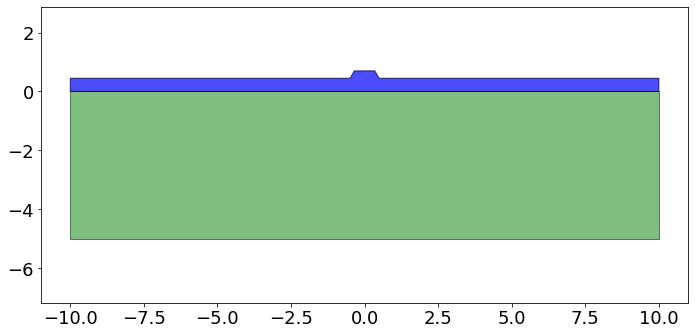

In [3]:
#Draw it
h_slab = h_LN - h_etch
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

plt.rcParams['figure.figsize'] = [10, 5]
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='k', facecolor='g', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

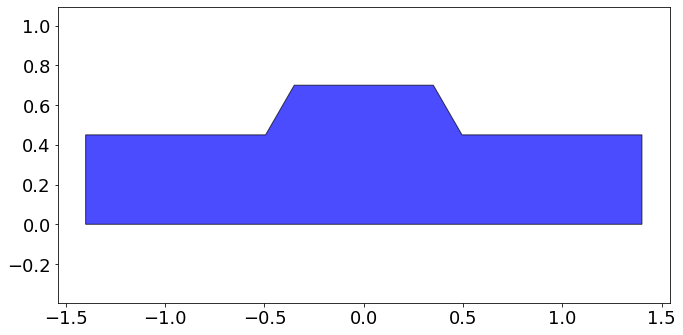

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,ax = plt.subplots()

v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [2*width_top, h_slab], [2*width_top ,0], 
                   [-2*width_top, 0], [-2*width_top, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

## Let's see some of the data

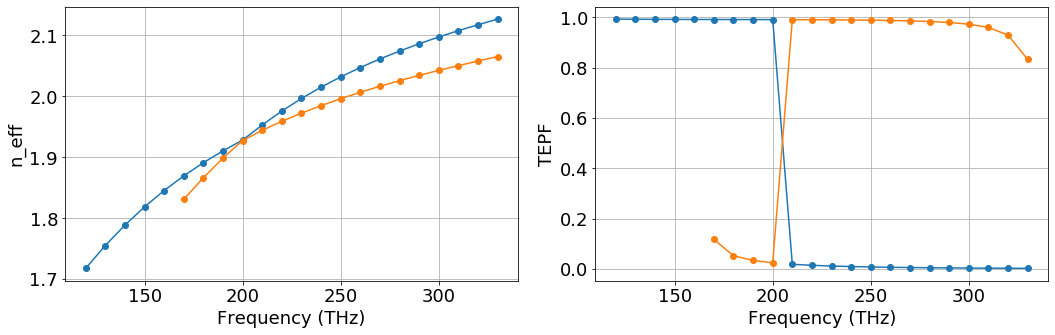

In [5]:
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(freqs/THz, neff,  marker='o');
ax2.plot(freqs/THz, tepf, marker='o');
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax2.set_xlabel('Frequency (THz)')
ax1.set_ylabel('n_eff')
ax2.set_ylabel('TEPF')
plt.tight_layout()

So, there's a mode crossing around 200 THz. Let's ignore this. Let's assume there's a single mode that is TE and covers over the whole band.

Let's choose that mode.

In [6]:
tepf[tepf != tepf] = 0 #get rid of nan
idx = tepf>0.8

tepf = tepf[idx]
neff = neff[idx]
ng = ng[idx]
modes = modes[idx]

Text(0, 0.5, 'TEPF')

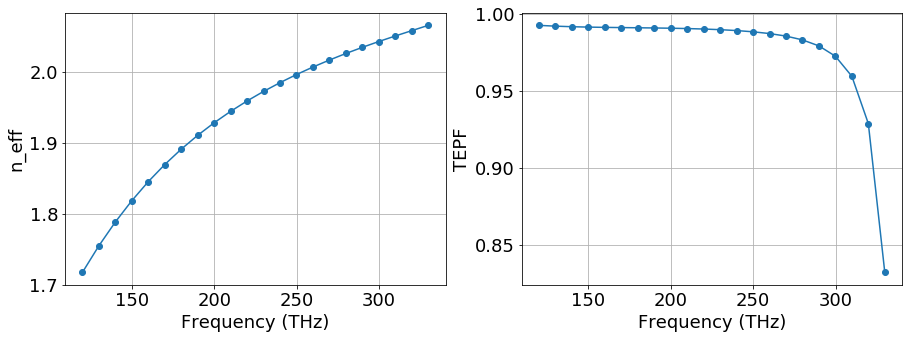

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(freqs/THz, neff,  marker='o');
ax2.plot(freqs/THz, tepf, marker='o');
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax2.set_xlabel('Frequency (THz)')
ax1.set_ylabel('n_eff')
ax2.set_ylabel('TEPF')

Let's look at the normalization constant from the modes.

Text(0, 0.5, 'N')

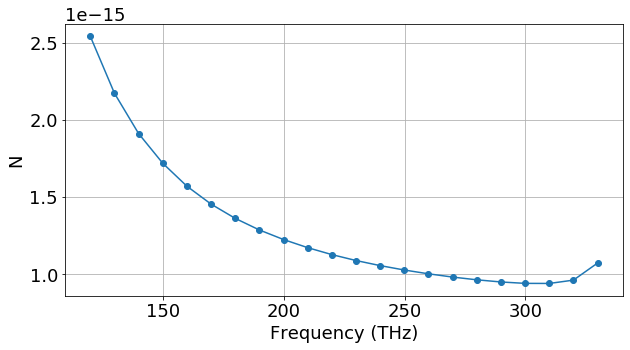

In [8]:
N = np.empty( neff.size )
for km in range(neff.size):
    N[km]  = modes[km].N()
    
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(freqs/THz, N,  marker='o');
ax1.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax1.set_ylabel('N')

### We can also look at the modes themselves.

In [9]:
x = modes[1].E.xx
y = modes[1].E.yy
X, Y = np.meshgrid(x,y)

In [10]:
def plot_mode(F, ax):
    xlim = [-2,2]
    
    #Draw the mode
    ax.pcolormesh(X/um, Y/um, (np.transpose(F)), cmap=cm.jet)
    
    #Draw the waveguide
    v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                       [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                       [xlim[1], h_slab], [xlim[1], 0], 
                       [xlim[0], 0], [xlim[0], h_slab] ] )/um
    
    ridge = patches.Polygon(v_ridge, linewidth=1.5, edgecolor='k', alpha=1, fill=False)

    ax.add_patch(ridge)

    #Make Pretty
    ax.set_xlim(xlim)
    ax.set_ylim([-2, 2])
    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')

In [11]:
def create_mask():
    mask = np.transpose(np.real(np.ones_like(modes[1].E.x)))
    mask[Y> (X+width_top/2+w_sidewall)*np.tan(theta*pi/180)+h_slab] = 0
    mask[Y> (-X+width_top/2+w_sidewall)*np.tan(theta*pi/180)+h_slab] = 0
    mask[Y < h_slab] = 1
    mask[Y>h_LN] = 0
    mask[Y<0] = 0
    return np.transpose(mask)

mask = create_mask()

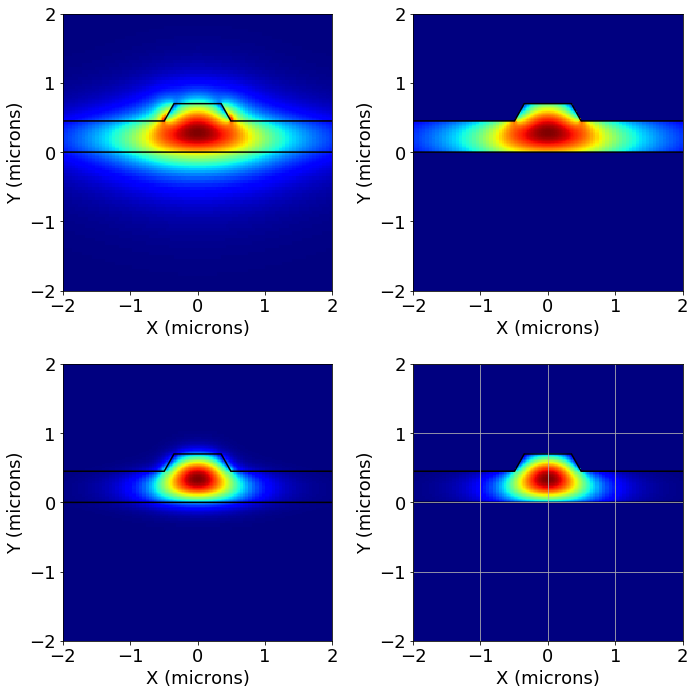

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]

F1 = np.real(modes[1].E.x)
F2 = np.real(modes[1].E.x * mask)
F3 = np.real(modes[-1].E.x)
F4 = np.real(modes[-1].E.x * mask)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plot_mode(F1, ax1)
plot_mode(F2, ax2)
plot_mode(F3, ax3)
plot_mode(F4, ax4)

ax4.grid(True)

plt.tight_layout()

## Nonlinear Polarization

Let's start with the nonlinear susceptibility tensor.

In [13]:
d31 = -4.6*pm
d22 = 2.2*pm
d33 = -25*pm

chi2 = np.zeros([3,3,3])
chi2[2,2,2] = 2*d33
chi2[([0,0,1,1,2,2], [2,0,1,2,0,1], [0,2,2,1,0,1])] = 2*d31
chi2[([1,1,0,0], [1,0,0,1], [1,0,1,0])] = 2*d22
chi2

array([[[ 0.0e+00,  2.2e-12, -4.6e-12],
        [ 2.2e-12,  0.0e+00,  0.0e+00],
        [-4.6e-12,  0.0e+00,  0.0e+00]],

       [[ 2.2e-12,  0.0e+00,  0.0e+00],
        [ 0.0e+00,  2.2e-12, -4.6e-12],
        [ 0.0e+00, -4.6e-12,  0.0e+00]],

       [[-4.6e-12,  0.0e+00,  0.0e+00],
        [ 0.0e+00, -4.6e-12,  0.0e+00],
        [ 0.0e+00,  0.0e+00, -2.5e-11]]])

We need to permute the axes of the fields to match the crystal labels, so x->z, y->x, z->y

In [14]:
def permute_axes(A):
    Bx = A.y
    By = A.z
    Bz = A.x
    return lum.field_2D(A.xx, A.yy, Bx, By, Bz)

In [15]:
def polarization(E1, E2):
    Px = np.zeros_like(E1.x)
    Py = np.zeros_like(E1.x)
    Pz = np.zeros_like(E1.x)
    
    Ea = np.array([E1.x, E1.y, E1.z])
    Eb = np.array([E2.x, E2.y, E2.z])
    
    for kj in range(3):
        for kz in range(3):
            Px = Px + chi2[0, kj, kz] * Ea[kj] * Eb[kz]
            Py = Py + chi2[1, kj, kz] * Ea[kj] * Eb[kz]
            Pz = Pz + chi2[2, kj, kz] * Ea[kj] * Eb[kz]
            
    Px = epsilon_0 * Px * mask
    Py = epsilon_0 * Py * mask
    Pz = epsilon_0 * Pz * mask
    
    P = lum.field_2D(E1.xx, E2.xx, Px, Py, Pz)
    return P

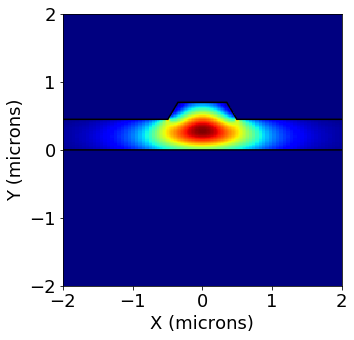

In [122]:
E1 = permute_axes(modes[1].E)
E2 = permute_axes(modes[1].E)
P = polarization(E1, E2)
F = np.abs(P.z)

plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot_mode(F, ax1)

## Overlap Integral

In [17]:
def X_func(Ea,Eb,Ec):
    
    #Need to map lumerical coordinate system to crystal axes
    z = Ea.xx #Horizontal Z-crystal
    x = Ea.yy #Vertical X-crystal
    
    E1 = permute_axes(Ea)
    E2 = permute_axes(Eb)
    E3 = permute_axes(Ec)
    
    P = polarization(E2,E3)
    integrand = P.dot(E1.conj())
    
    return simps(simps(integrand, x), z)

In [76]:
def get_X_array(N):
    X_array = 1j * np.zeros([freqs.size, freqs.size])
    for k1 in range(wavelength.size):
        for k2 in range(wavelength.size):
            f1 = freqs[k1]
            f2 = freqs[k2]

            k3 = np.argwhere(np.isclose(freqs, np.abs(f1 - f2), atol=fstep/10))
            if k3.size != 0:
                k3 = k3[0, 0]
                f3 = freqs[k3]

                E1 = permute_axes(modes[k1].E)
                E2 = permute_axes(modes[k2].E)
                E3 = permute_axes(modes[k3].E)

                N1 = N[k1]
                N2 = N[k2]
                N3 = N[k3]

                E1.rescale(1/np.sqrt(N1))
                E2.rescale(1/np.sqrt(N2))
                E3.rescale(1/np.sqrt(N3))

                if f3<0:
                    E3 = E3.conj()

                X_array[k1, k2] = X_func(E1, E2, E3)

    X_array[X_array == 0] = np.nan
    return X_array

In [91]:
def ratio(X_array):
    r = np.nanmax(np.abs(X_array))/np.nanmin(np.abs(X_array))
    print(r)
    return r

In [83]:
X_array_norm = get_X_array(N)
X_array_lum = get_X_array(np.ones_like(freqs))

ratio(X_array_norm)
ratio(X_array_lum)

1.2904486393604835
1.359984841516116


Let's try a linear variation in N

In [93]:
# n_stop = np.arange(1.86, 1.94, 0.01)
# ratio_sweep = np.zeros_like(n_stop)

# for kn in range(n_stop.size):
#     Ntest = np.linspace(n_stop[kn], 1, num=freqs.size)
#     ratio_sweep[kn] = ratio(get_X_array(Ntest))

1.0632157627124381
1.0617628582745695
1.0603210095676934
1.0588900745947083
1.0574699139962689
1.0568276056849113
1.0580514241699757
1.0593179602696876


In [ ]:
N_opt = np.linspace(1.91, 1, num=freqs.size)
X_array_opt = get_X_array(N_opt)

1.0568276056849115


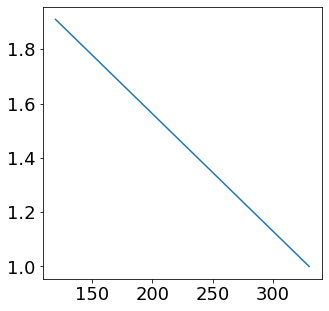

In [123]:
ratio(X_array_opt)
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(freqs/THz, N_opt)

In [114]:
np.nanmax(np.abs(X_array_nonorm))

7.734452951401297e-36

In [113]:
np.nanmin(np.abs(X_array_nonorm))

5.687161147163156e-36

In [126]:
np.nanmin(np.abs(X_array_opt))

3.2523710038736445e-36

In [127]:
np.nanmax(np.abs(X_array_opt))

3.437195460822816e-36

Text(0, 0.5, 'f2')

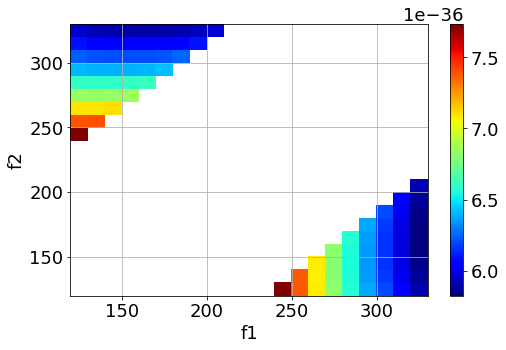

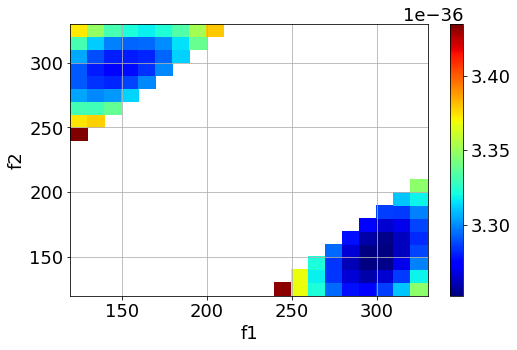

In [155]:
F1, F2 = np.meshgrid(freqs/THz, freqs/THz)

plt.rcParams['figure.figsize'] = [8, 5]

vmin = 3e-36
vmax = 8e-36

plt.figure()
plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_nonorm))), cmap=cm.jet)
plt.colorbar()
plt.grid(True)
plt.xlabel('f1')
plt.ylabel('f2')

plt.figure()
plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_opt))), cmap=cm.jet)
plt.colorbar()
plt.grid(True)
plt.xlabel('f1')
plt.ylabel('f2')

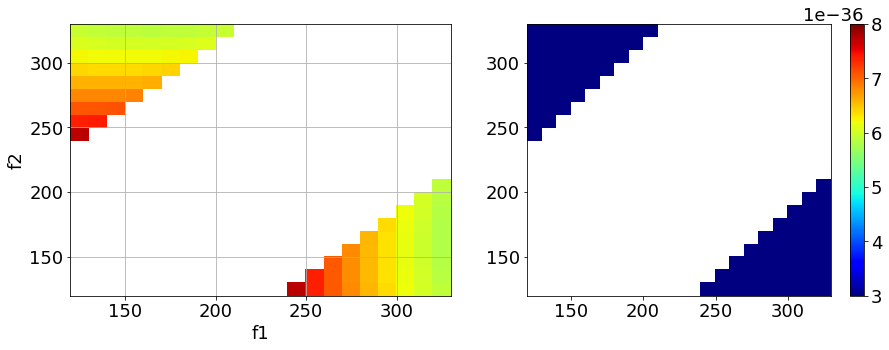

In [142]:
F1, F2 = np.meshgrid(freqs/THz, freqs/THz)

plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

vmin = 3e-36
vmax = 8e-36

im1 = ax1.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_nonorm))), cmap=cm.jet, vmin=vmin, vmax=vmax)
im2 = ax2.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_opt))), cmap=cm.jet, vmin=vmax, vmax=vmax)

ax1.grid(True)
ax1.set_xlabel('f1')
ax1.set_ylabel('f2' )

fig.colorbar(im1)